In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import kpss
import statsmodels.tsa.stattools as tsa
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [80]:
import warnings # Desactivar todas las advertencias
warnings.filterwarnings("ignore")

In [81]:
fact_full = pd.read_excel('.\Data\Descarga_FACTURADO_CLIENTES_NB_240823.xlsx',skiprows=1)
df_fact = fact_full.groupby(by = 'Periodo', sort = True)['Suma Total'].sum().reset_index()
df_fact.rename(columns={'Periodo': 'mes', 'Suma Total': 'fact'}, inplace = True)
df_fact.set_index('mes', inplace = True)
df_fact.head()

,fact
mes,
2019-01-01,22150781.76
2019-02-01,20681481.53
2019-03-01,22316953.30
2019-04-01,22943028.41
2019-05-01,22975503.75


In [82]:
vent_full = pd.read_excel('.\Data\Descarga_VENTAS_POR_LOCALES_NB_050923.xlsx',skiprows=1)
df_vent = vent_full.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_vent.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_vent.mes = pd.to_datetime(df_vent.mes, dayfirst = True, format = '%m/%Y')
df_vent = df_vent.sort_values(by = 'mes')
df_vent.set_index('mes', inplace = True)
df_vent.head()

,ventas
mes,
2015-01-01,62633592.89
2015-02-01,62563213.35
2015-03-01,70487376.77
2015-04-01,68644186.80
2015-05-01,70835132.46


In [83]:
df_ipc = pd.read_excel('.\Data\Tabla_IPC.xlsx',skiprows=1)
df_ipc.rename(columns={'Fecha': 'fecha', 'Indice': 'ipc'}, inplace = True)
df_ipc.set_index('fecha', inplace=True)
df_ipc.head()

,ipc
fecha,
2016-12-01,100.0000
2017-01-01,101.5859
2017-02-01,103.6859
2017-03-01,106.1476
2017-04-01,108.9667


In [84]:
df_usd = pd.read_excel('.\Data\Dolar_Evolución.xlsx',skiprows=0)
df_usd = df_usd.iloc[:, 1:]
df_usd.columns = ['fecha', 'ofi', 'blue']
df_usd.set_index('fecha', inplace=True)
df_usd.head()

,ofi,blue
fecha,,
2015-01-01,8.55,13.50
2015-02-01,8.63,12.93
2015-03-01,8.72,12.52
2015-04-01,8.81,12.60
2015-05-01,8.90,12.55


In [85]:
df_retail = vent_full[(vent_full['Razón Social'] != 'GD WORK SA') & (vent_full['Rubro'] != 'SUPERMERCADO')]
df_retail = df_retail.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_retail.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_retail.mes = pd.to_datetime(df_retail.mes, dayfirst = True, format = '%m/%Y')
df_retail = df_retail.sort_values(by = 'mes')
df_retail.set_index('mes', inplace = True)
df_retail.head()

,ventas
mes,
2015-01-01,35881254.22
2015-02-01,35994300.23
2015-03-01,41635908.20
2015-04-01,41074614.00
2015-05-01,43747283.60


In [86]:
df_super = vent_full[vent_full['Rubro'] == 'SUPERMERCADO']
df_super = df_super.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_super.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_super.mes = pd.to_datetime(df_super.mes, dayfirst = True, format = '%m/%Y')
df_super = df_super.sort_values(by = 'mes')
df_super.set_index('mes', inplace = True)
df_super.head()

,ventas
mes,
2015-01-01,26752338.67
2015-02-01,26568913.12
2015-03-01,28851468.57
2015-04-01,27569572.80
2015-05-01,27087848.86


In [87]:
df_cowork = vent_full[vent_full['Razón Social'] == 'GD WORK SA']
df_cowork = df_cowork.groupby(by = 'Periodo', sort = True)['Importe'].sum().reset_index()
df_cowork.rename(columns={'Periodo': 'mes', 'Importe': 'ventas'}, inplace = True)
df_cowork.mes = pd.to_datetime(df_cowork.mes, dayfirst = True, format = '%m/%Y')
df_cowork = df_cowork.sort_values(by = 'mes')
df_cowork.set_index('mes', inplace = True)
df_cowork.head()

,ventas
mes,
2019-01-01,824754.21
2019-02-01,983820.43
2019-03-01,1281202.80
2019-04-01,2000058.99
2019-05-01,1787994.13


In [88]:
#df_ipc.reset_index(inplace=True)
df_ipc['ipc_previo'] = df_ipc['ipc'].shift(1)
df_ipc['ipc_intermensual'] = (df_ipc['ipc'] - df_ipc['ipc_previo']) / df_ipc['ipc']
#df_ipc.set_index

In [89]:

def filtrar_serie(serie, start_date, end_date):
    serie = serie[(serie.index >= start_date) & (serie.index <= end_date)]
    return serie

In [90]:
df_vent = filtrar_serie(df_vent, '2017-01-01', '2023-08-01')
df_retail = filtrar_serie(df_retail, '2017-01-01', '2023-08-01')
df_cowork = filtrar_serie(df_cowork, '2017-01-01', '2023-08-01')
df_super = filtrar_serie(df_super, '2017-01-01', '2023-08-01')
df_usd = filtrar_serie(df_usd, '2017-01-01', '2023-08-01')

In [91]:
def corregir_usd_ipc(serie, ipc, dolar):
    corregida = serie / (1 + ipc)
    corregida = corregida / dolar
    return corregida

In [92]:
df_vent['ventas_ajustado'] = corregir_usd_ipc(df_vent['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_cowork['ventas_ajustado'] = corregir_usd_ipc(df_cowork['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_retail['ventas_ajustado'] = corregir_usd_ipc(df_retail['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])
df_super['ventas_ajustado'] = corregir_usd_ipc(df_super['ventas'], df_ipc['ipc_intermensual'], df_usd['blue'])

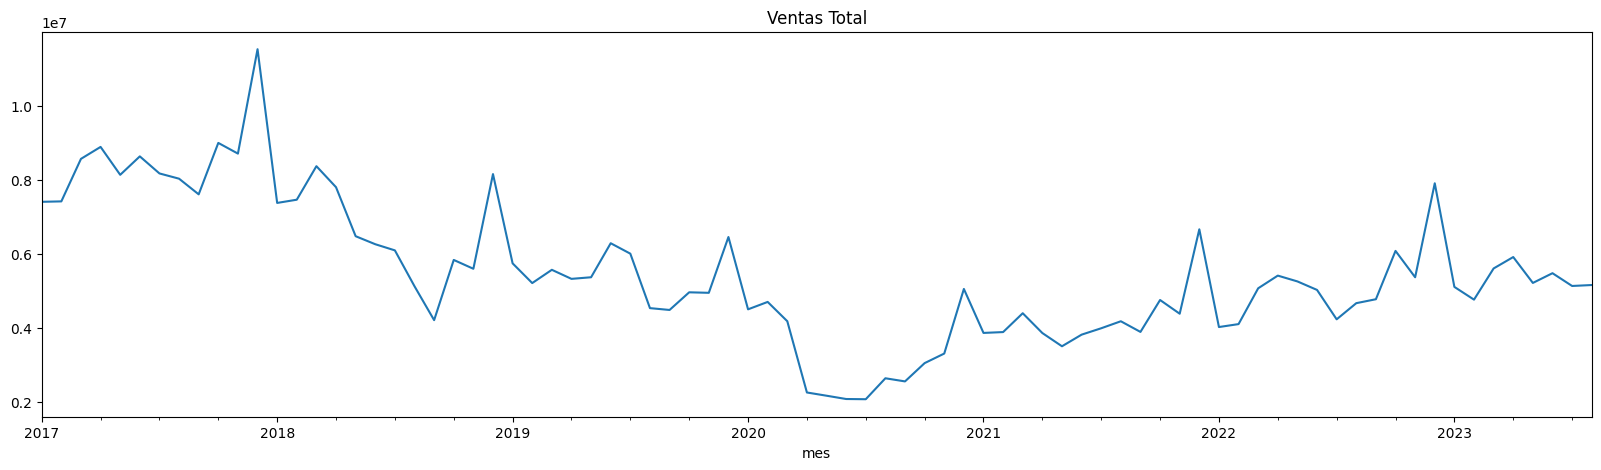

In [93]:
df_vent.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Total")
plt.show()

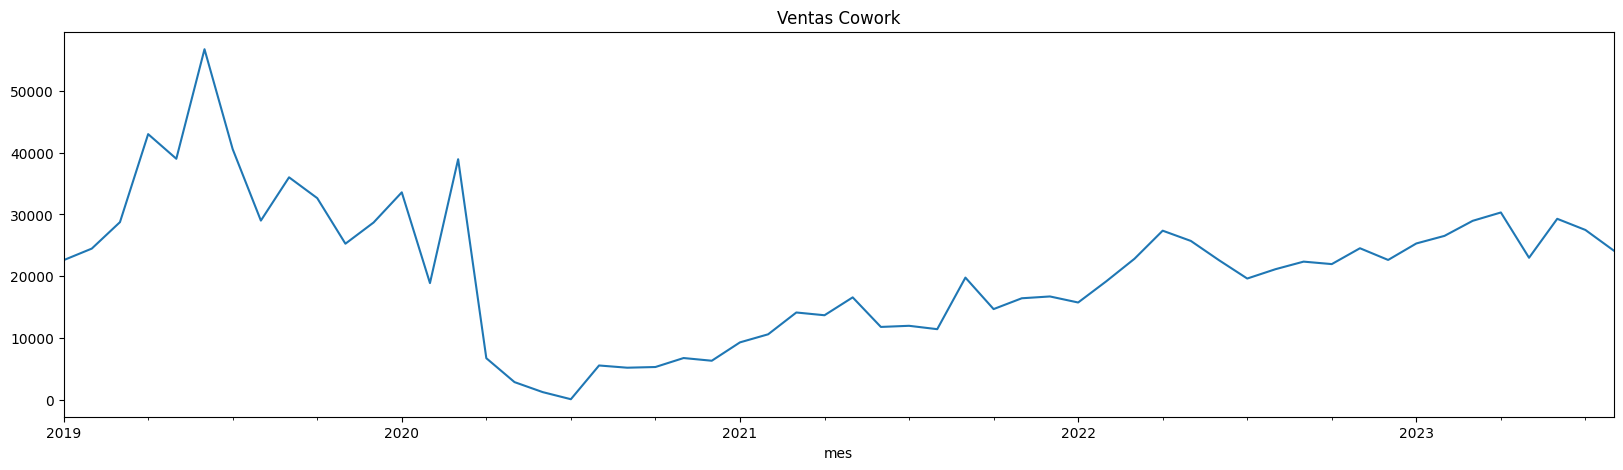

In [94]:
df_cowork.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Cowork")
plt.show()

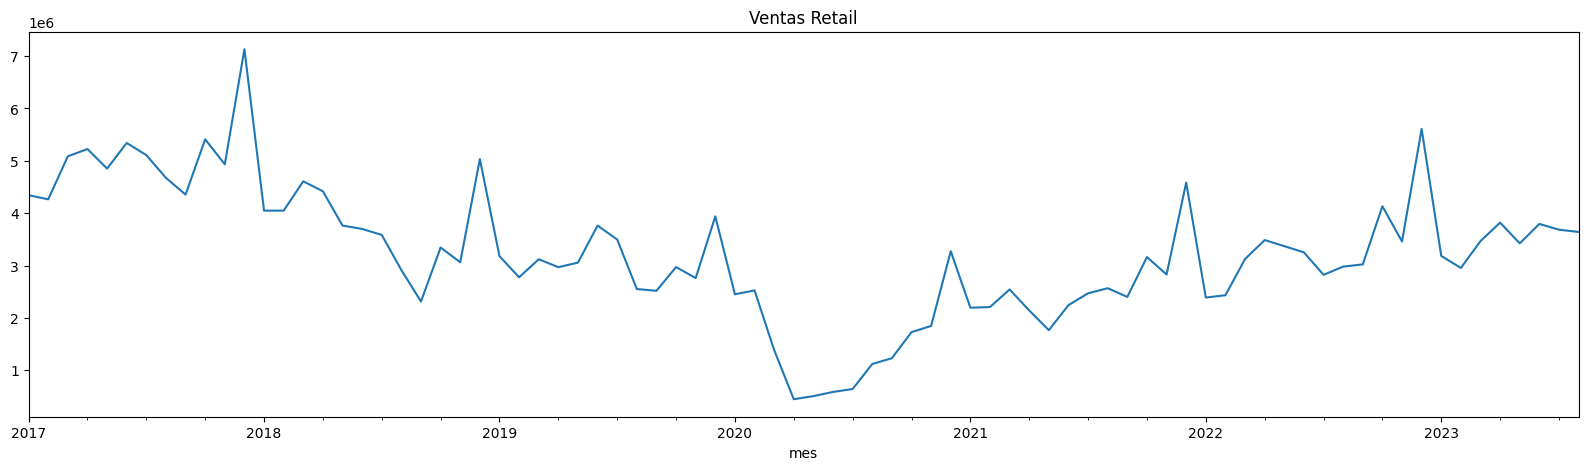

In [95]:
df_retail.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Retail")
plt.show()

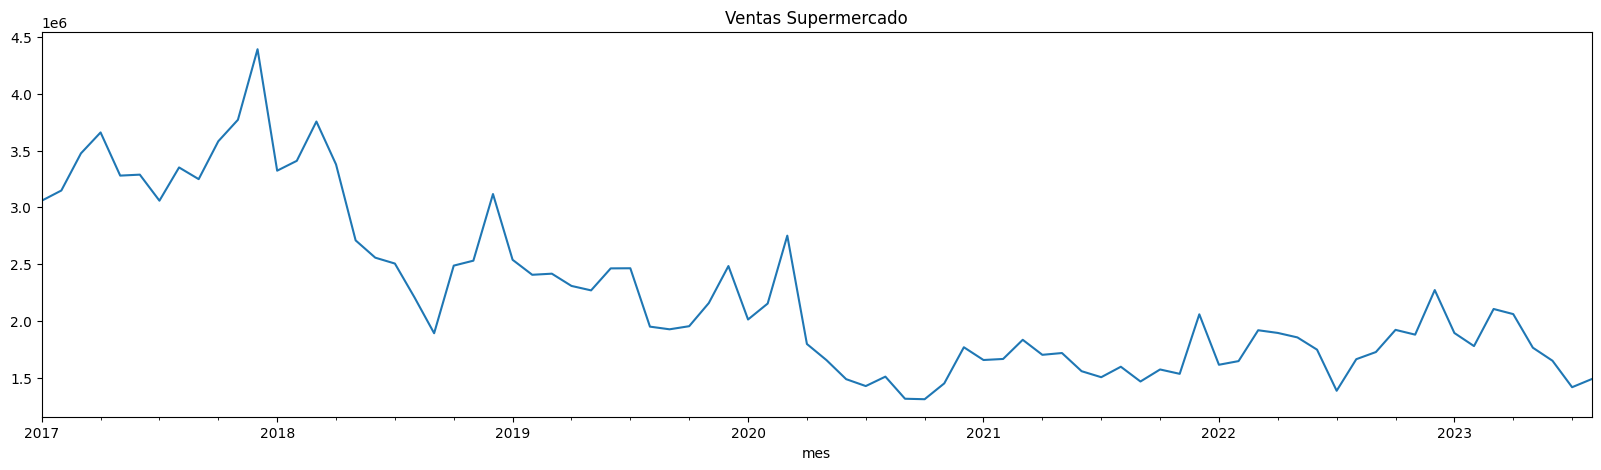

In [96]:
df_super.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Supermercado")
plt.show()

Arranca analisis

Inciso 2 -  Grafico de la serie original

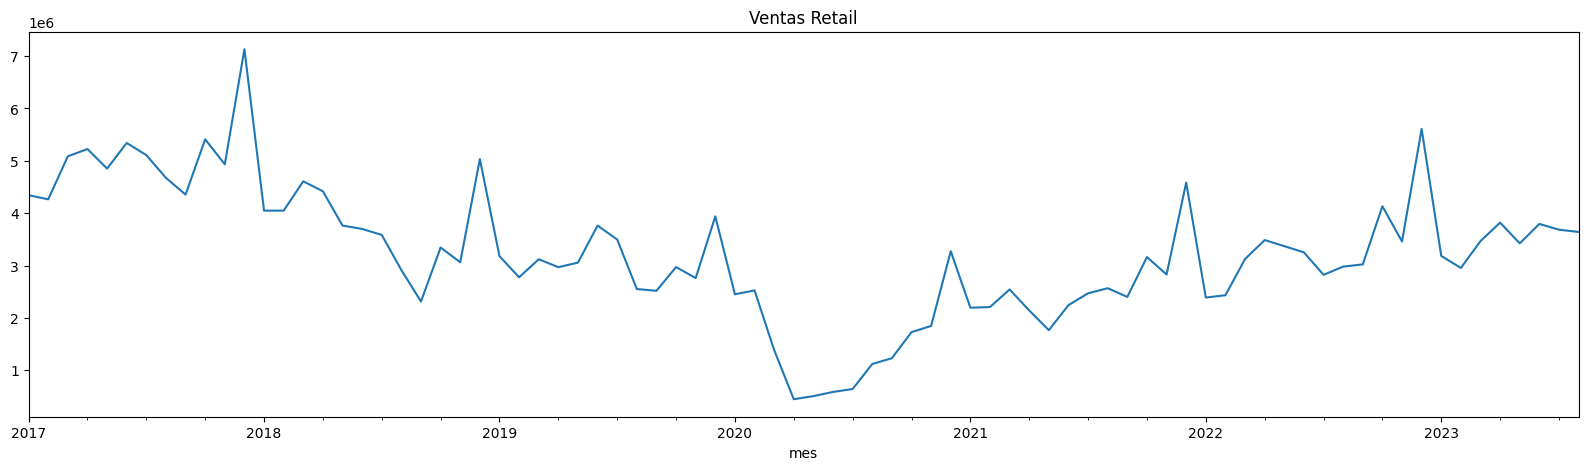

In [97]:
df_retail.ventas_ajustado.plot(figsize=(20,5), title = "Ventas Retail")
plt.show()

a simple vista no es estacionaria

Inciso 3 - Funciones de ACF y PACF

In [98]:
df_retail['diff1'] = df_retail.ventas_ajustado.diff(periods = 1)
df_retail.diff1[0] = 0

In [99]:
## Función para dibujar juntos FAS: autocovarianzas; FAC (autocorrelacion ) y FACP (autocorrelación parcial)
def autocov_autocorr(serie_r,serie_nr, nrol= 75 ):
  p1, axes=plt.subplots(3,2,figsize=(18,10),sharex=True, sharey=False )
  axes[2,0].set_xlabel('Lag')
  axes[2,1].set_xlabel('Lag')

  plot_acf(serie_r, lags=nrol, ax= axes[0,0], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title=serie_r.name )
  plot_pacf(serie_r, lags=nrol, ax= axes[1,0], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,0].plot(tsa.acovf(serie_r,fft=False, nlag=nrol), color='r', label='AutoCov')

  plot_acf(serie_nr, lags=nrol, ax= axes[0,1], color='blue', label="ACF", vlines_kwargs={"colors":'blue'}, title=serie_nr.name)
  plot_pacf(serie_nr, lags=nrol, ax= axes[1,1], color='green', label="PACF", vlines_kwargs={"colors":'green'}, title='', method='ywm')
  axes[2,1].plot(tsa.acovf(serie_nr,fft=False, nlag=nrol), color='r', label='AutoCov')

  p1.legend()
  plt.show()

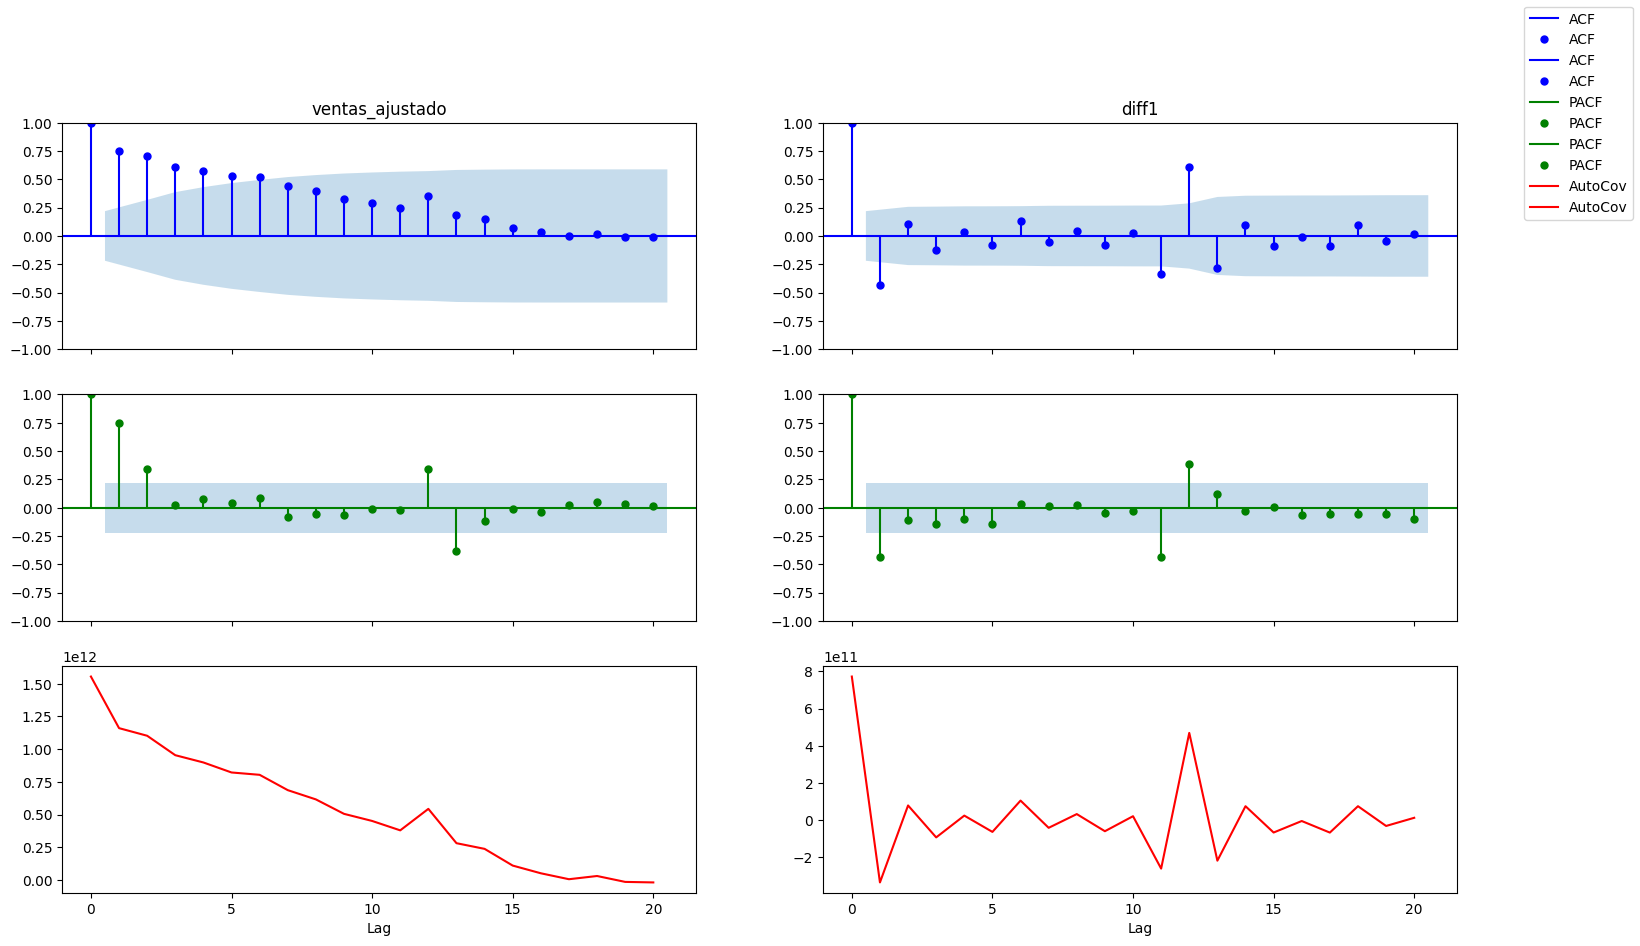

In [100]:
autocov_autocorr(df_retail.ventas_ajustado, df_retail.diff1, 20)

Inciso 4 - Pruebas de raices unitarias

In [101]:
def print_test_adf(y):
  resultado = adfuller(y, regression='c')
  print(f'Estadistico ADF: {resultado[0]:.4f} \t p-valor: {resultado[1]:.4f} Constante sola')
  resultado = adfuller(y, regression='ct')
  print(f'Estadistico ADF: {resultado[0]:.4f} \t p-valor: {resultado[1]:.4f} Constante y Tendencia Lineal')
  resultado = adfuller(y, regression='ctt')
  print(f'Estadistico ADF: {resultado[0]:.4f} \t p-valor: {resultado[1]:.4f} Constante y Tendencia Lineal y Cuadratica')
  resultado = adfuller(y, regression='n')
  print(f'Estadistico ADF: {resultado[0]:.4f} \t p-valor: {resultado[1]:.4f} Sin Contante ni Tendencia')


In [102]:
print_test_adf(df_retail.ventas_ajustado)

Estadistico ADF: -2.1134 	 p-valor: 0.2391 Constante sola
Estadistico ADF: -1.5532 	 p-valor: 0.8102 Constante y Tendencia Lineal
Estadistico ADF: -2.7274 	 p-valor: 0.4387 Constante y Tendencia Lineal y Cuadratica
Estadistico ADF: -0.7234 	 p-valor: 0.4027 Sin Contante ni Tendencia


In [103]:
from arch.unitroot import PhillipsPerron

In [104]:
def Phillips_Perron(series, **k):

    params = {'n':'No incluye término independiente ni lineal',
              'c':'Incluya término independiente pero no incluye término lineal',
              'ct':'Incluya ambos términos'
              }
    for param in params:
        print(f'Tipo de regresión: {param} - {params.get(param)}')
        pp = PhillipsPerron(series,trend=param, **k)
        print(f'PP Estadistico: {pp.stat}')
        print(f'p-valor: {pp.pvalue}')
        print(f'numero de lags: {pp.lags}')
        print('Valor Critico:')
        for key, value in pp.critical_values.items():
            print(f'   {key} : {value}')
        print(f'Resultado: La serie es {"no " if pp.pvalue > 0.05 else ""}estacionaria')
        print(f"PP Numero de diferenciacion estimada: {ndiffs(series, test='pp')}")

        print("*".center(60, '*'))
        print("")

In [105]:
Phillips_Perron(df_retail.ventas_ajustado)

Tipo de regresión: n - No incluye término independiente ni lineal
PP Estadistico: -0.8730458328385109
p-valor: 0.34000625755403735
numero de lags: 12
Valor Critico:
   1% : -2.5946224226886714
   5% : -1.9448758487665276
   10% : -1.6138413966846434
Resultado: La serie es no estacionaria
PP Numero de diferenciacion estimada: 1
************************************************************

Tipo de regresión: c - Incluya término independiente pero no incluye término lineal
PP Estadistico: -3.616186018442617
p-valor: 0.005459019683554174
numero de lags: 12
Valor Critico:
   1% : -3.5159766913976376
   5% : -2.898885703483903
   10% : -2.5866935058484217
Resultado: La serie es estacionaria
PP Numero de diferenciacion estimada: 1
************************************************************

Tipo de regresión: ct - Incluya ambos términos
PP Estadistico: -3.961294752155389
p-valor: 0.009973005152350852
numero de lags: 12
Valor Critico:
   1% : -4.078193339938625
   5% : -3.467604557671908
   1

In [106]:
def kpss_test(series, **kw):

    params = {'c':'Los datos son estacionarios alrededor de una constante.',
              'ct': 'Los datos son estacionarios alrededor de una tendencia.'
             }

    for param in params:
        print(f'Tipo de regresión: {param} - {params.get(param)}')

        statistic, p_value, n_lags, critical_values = kpss(series,regression = param, **kw)
        # Format Output
        print(f'KPSS Estadistico: {statistic}')
        print(f'p-valor: {p_value}')
        print(f'numero de lags: {n_lags}')
        print('Valor critico:')
        for key, value in critical_values.items():
            print(f'   {key} : {value}')
        print(f'Resultado: La serie es {"no " if p_value < 0.05 else ""}estacionaria')
        print(f"KPSS Numero estimado de diferencias a aplicar: {ndiffs(series, test='kpss')}")

        print("*".center(60, '*'))
        print("")

In [107]:
kpss_test(df_retail.ventas_ajustado)

Tipo de regresión: c - Los datos son estacionarios alrededor de una constante.
KPSS Estadistico: 0.4973259506360773
p-valor: 0.042268930036919526
numero de lags: 5
Valor critico:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Resultado: La serie es no estacionaria
KPSS Numero estimado de diferencias a aplicar: 1
************************************************************

Tipo de regresión: ct - Los datos son estacionarios alrededor de una tendencia.
KPSS Estadistico: 0.2969823601371599
p-valor: 0.01
numero de lags: 5
Valor critico:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Resultado: La serie es no estacionaria
KPSS Numero estimado de diferencias a aplicar: 1
************************************************************



Hasta ahora comprobamos que la serie original no es estacionaria

Pero los tests nos dan indicios de que la primer diferencia podria funcionar

arIma para todos

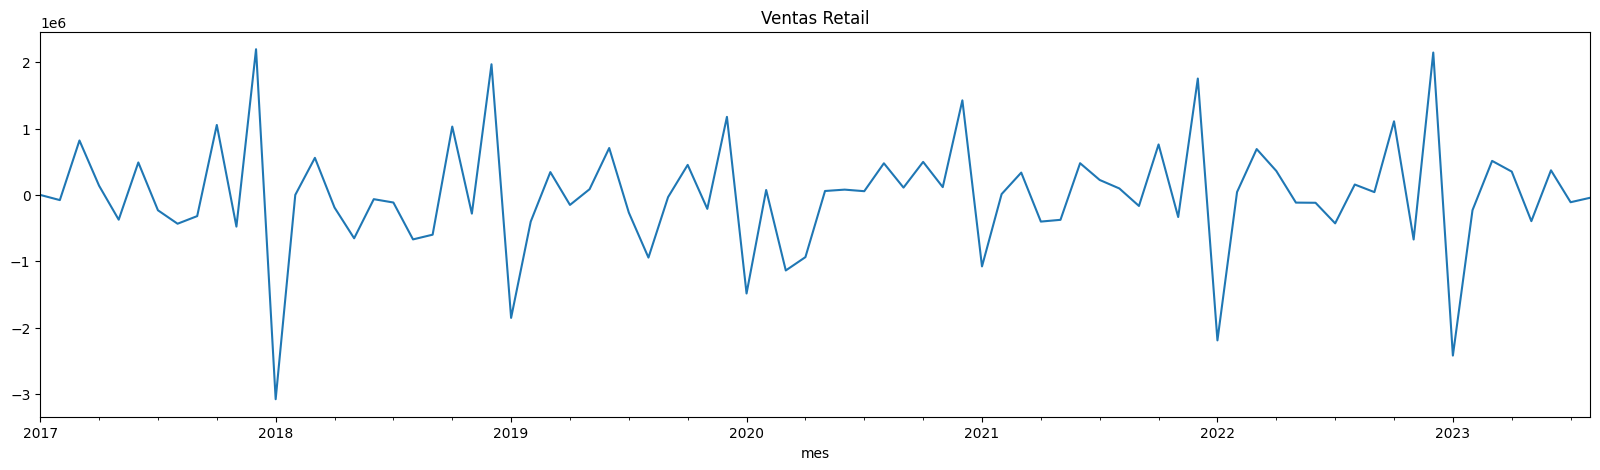

Estadistico ADF: -2.7607 	 p-valor: 0.0641 Constante sola
Estadistico ADF: -4.3799 	 p-valor: 0.0024 Constante y Tendencia Lineal
Estadistico ADF: -4.0866 	 p-valor: 0.0245 Constante y Tendencia Lineal y Cuadratica
Estadistico ADF: -2.6607 	 p-valor: 0.0076 Sin Contante ni Tendencia
Tipo de regresión: n - No incluye término independiente ni lineal
PP Estadistico: -18.042641384230386
p-valor: 5.0060673041025104e-29
numero de lags: 12
Valor Critico:
   1% : -2.5946224226886714
   5% : -1.9448758487665276
   10% : -1.6138413966846434
Resultado: La serie es estacionaria
PP Numero de diferenciacion estimada: 0
************************************************************

Tipo de regresión: c - Incluya término independiente pero no incluye término lineal
PP Estadistico: -17.993586851895877
p-valor: 2.749141302693277e-30
numero de lags: 12
Valor Critico:
   1% : -3.5159766913976376
   5% : -2.898885703483903
   10% : -2.5866935058484217
Resultado: La serie es estacionaria
PP Numero de diferen

In [108]:
df_retail.diff1.plot(figsize=(20,5), title = "Ventas Retail")
plt.show()

print_test_adf(df_retail.diff1)

Phillips_Perron(df_retail.diff1)

kpss_test(df_retail.diff1)


Inciso 5 - SARIMAX

In [109]:
sarimax = auto_arima(df_retail.ventas_ajustado,
                     start_p=1, max_p=12,
                     start_d=1, max_d=3,
                     start_q=1, max_q=12,
                     start_P=0, max_P=12,
                     start_D=0, max_D=12,
                     start_Q=0, max_Q=12,
           seasonal=True, m=12, trace=True, stepwise=True)

Performing stepwise search to minimize aic


 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2383.102, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2391.582, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2376.702, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2378.544, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2389.596, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2380.998, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2378.115, Time=0.12 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2377.113, Time=0.13 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2377.577, Time=0.04 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=2379.077, Time=0.30 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=2382.804, Time=0.03 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2378.722, Time=0.06 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2378.813, Time=0.08 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2377.678, Time=0.04 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=2380.329, Time=0.2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    SARIMAX Results                                    
=======================================================================================
Dep. Variable:                 ventas_ajustado   No. Observations:                   80
Model:             ARIMA([1, 11, 12], 1, [12])   Log Likelihood                   0.000
Date:                         Tue, 31 Oct 2023   AIC                             10.000
Time:                                 22:23:32   BIC                             21.847
Sample:                             01-01-2017   HQIC                            14.746
                                  - 08-01-2023                                         
Covariance Type:                           opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.7886         -0       -inf      0.000       2.789       2.789
ar.L11        -2.7221         -0        inf      0.000      -2.722      -2.722
ar.L12         0.9302         -0       -inf      0.000       0.930       0.930
ma.L12         0.6563         -0       -inf      0.000       0.656       0.656
sigma2      2.535e+11         -0       -inf      0.000    2.53e+11    2.53e+11
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                  nan
Prob(Q):                               nan   Prob(JB):                          nan
Heteroskedasticity (H):                nan   Skew:                              nan
Prob(H) (two-sided):                   nan   Kurtosis:                          nan
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

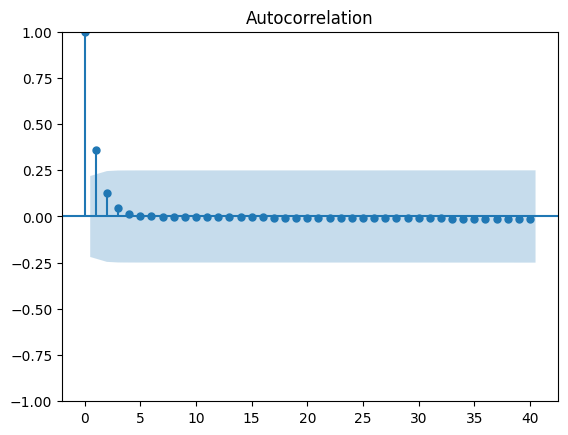

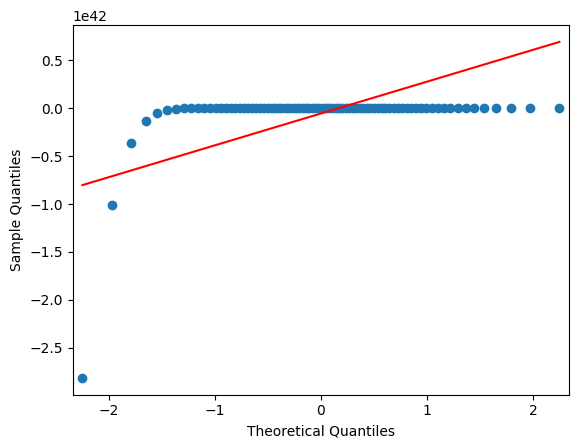

In [146]:
import statsmodels.tsa.arima 
import matplotlib.pyplot as plt
retail_fit = statsmodels.tsa.arima.model.ARIMA(df_retail.ventas_ajustado,order=((1,0,0,0,0,0,0,0,0,0,1,1),1,(0,0,0,0,0,0,0,0,0,0,0,1))).fit()
statsmodels.api.graphics.tsa.plot_acf(retail_fit.resid, lags=40)
statsmodels.api.qqplot(retail_fit.resid, line='s')
statsmodels.api.stats.acorr_ljungbox(retail_fit.resid, lags=[10], return_df=True)
retail_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                         
================================================================================================
Dep. Variable:                          ventas_ajustado   No. Observations:                   80
Model:             SARIMAX([1, 11], 1, 0)x(1, 0, 0, 12)   Log Likelihood                -306.996
Date:                                  Tue, 31 Oct 2023   AIC                            621.992
Time:                                          22:23:28   BIC                            631.470
Sample:                                      01-01-2017   HQIC                           625.789
                                           - 08-01-2023                                         
Covariance Type:                                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4492      0.251     -5.764      0.000      -1.942      -0.956
ar.L11        -0.5066      0.102     -4.979      0.000      -0.706      -0.307
ar.S.L12      -0.9875      0.009   -112.253      0.000      -1.005      -0.970
sigma2      5.198e+11   2.82e-13   1.85e+24      0.000     5.2e+11     5.2e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.43   Jarque-Bera (JB):              1695.07
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -2.57
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.54e+39. Standard errors may be unstable.
"""

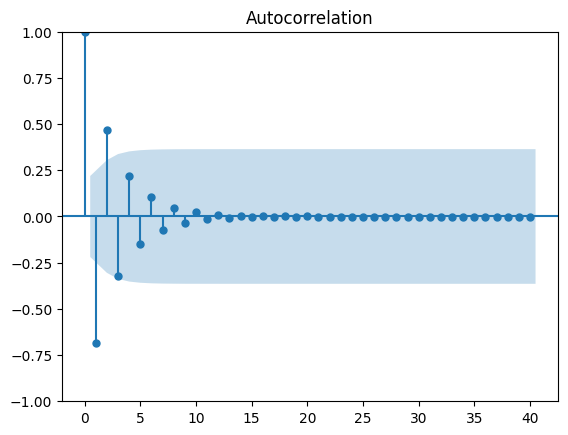

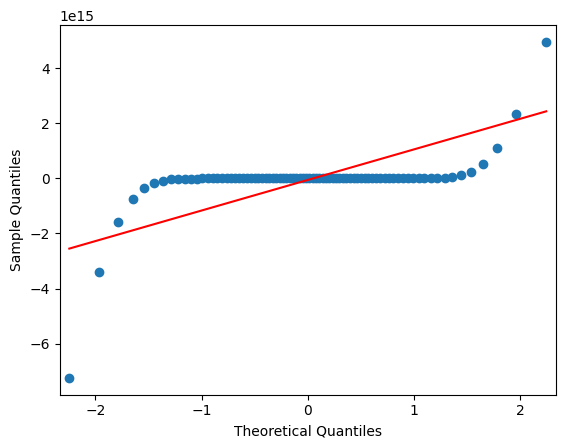

In [145]:
import statsmodels.tsa.arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
retail_fit_seasonal = SARIMAX(df_retail.ventas_ajustado,
                                   order=((1,0,0,0,0,0,0,0,0,0,1),1,(0,0,0,0,0,0,0,0,0,0,0)),
                                   seasonal_order=(1,0,0,12)).fit()
statsmodels.api.graphics.tsa.plot_acf(retail_fit_seasonal.resid, lags=40)
statsmodels.api.qqplot(retail_fit_seasonal.resid, line='s')
statsmodels.api.stats.acorr_ljungbox(retail_fit_seasonal.resid, lags=[10], return_df=True)
retail_fit_seasonal.summary()

In [147]:
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   80
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -1184.329
Date:                            Tue, 31 Oct 2023   AIC                           2374.658
Time:                                    22:23:47   BIC                           2381.766
Sample:                                01-01-2017   HQIC                          2377.505
                                     - 08-01-2023                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2898      0.064     -4.560      0.000      -0.414      -0.165
ar.S.L12       0.2599      0.050      5.210      0.000       0.162       0.358
sigma2      6.422e+11   1.57e-14    4.1e+25      0.000    6.42e+11    6.42e+11
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):                71.02
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                            -0.79
Prob(H) (two-sided):                  0.04   Kurtosis:                         7.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

Inciso 6 - Predecir

In [113]:
# Separacion Train/Test
train = df_retail.iloc[:round(len(df_retail)*.80)].ventas_ajustado
test = df_retail.iloc[round(len(df_retail)*.80):].ventas_ajustado

In [114]:
modelo_sarima = SARIMAX(train, order=(1,1,0), seasonal_order=(1,0,0,12))
modelo_sarima = modelo_sarima.fit()
print(modelo_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                    ventas_ajustado   No. Observations:                   64
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 12)   Log Likelihood                -946.511
Date:                            Tue, 31 Oct 2023   AIC                           1899.022
Time:                                    22:01:13   BIC                           1905.452
Sample:                                01-01-2017   HQIC                          1901.551
                                     - 04-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2737      0.075     -3.627      0.000      -0.422      -0.126
ar.S.L12       0.1545      0.056   

In [115]:
# Función para graficar

def graficar_pred(serie_test, serie_pred, conf_int, titulo="Valores Originales vs Predicciones", xlabel="Año", ylabel="Pasajeros"):
    fig_x = plt.figure(figsize=(12,3), dpi=100)
    axes_x = fig_x.add_axes([0.0, 0.0, 1, 1])

    # Graficamos los datos tests y las predicciones
    serie_test.plot(label="Serie Original de Test")
    serie_pred.plot(label="Predicciones")

    # Pasamos dataframe con los intervalos de confianza a series de Pandas y graficamos
    conf_int.iloc[:,1].plot(label="Intervalo de Confianza Superior")
    conf_int.iloc[:,0].plot(label="Intervalo de Confianza Inferior")

    axes_x.set_xlabel(xlabel)
    axes_x.set_ylabel(ylabel)
    axes_x.set_title(titulo)
    axes_x.legend(loc=0)
    axes_x.grid(True, color='0.6', dashes=(5,2,1,2))

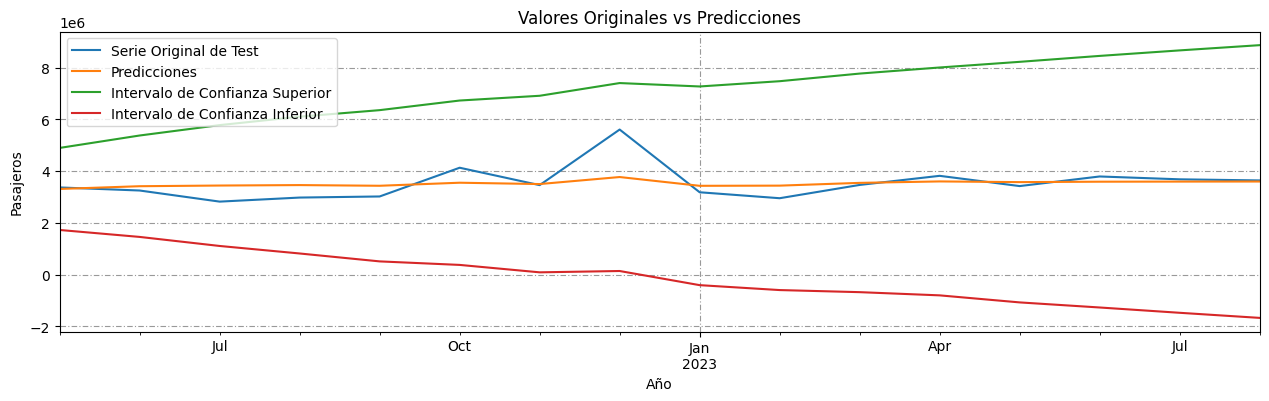

In [116]:
# Utilizando el modelo realizamos la prediccion correspondiente a los primeros 15 días del test
predicciones_sarima = modelo_sarima.get_forecast(16)

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test[:16], predicciones_sarima.predicted_mean, predicciones_sarima.conf_int())

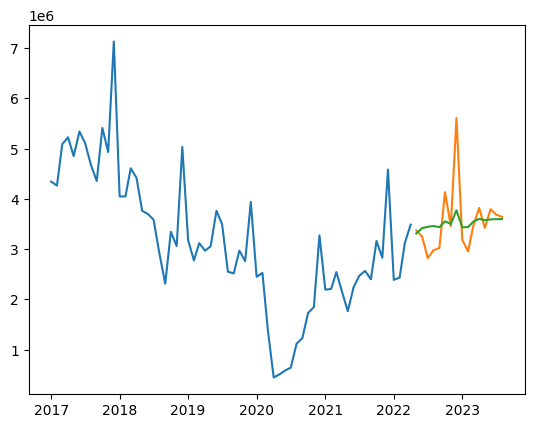

In [117]:
plt.plot(train)
plt.plot(test)
plt.plot(predicciones_sarima.predicted_mean)

In [118]:
def evaluar_metricas(serie_test, serie_pred):
    print(f'MSE: {mean_squared_error(serie_test, serie_pred)}')
    print(f'MAE: {mean_absolute_error(serie_test, serie_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(serie_test, serie_pred))}')
    print(f'MAPE: {round(np.mean(abs((serie_test-serie_pred)/serie_test)),4)}')

In [119]:
evaluar_metricas(test[:16], predicciones_sarima.predicted_mean )

MSE: 309256970025.1567
MAE: 357020.72522819834
RMSE: 556108.7753534884
MAPE: 0.0951


In [120]:
modelo_arima = SARIMAX(train, order=(1,1,0), seasonal_order=(0,0,0,0))
modelo_arima = modelo_arima.fit()
print(modelo_arima.summary())

                               SARIMAX Results                                
Dep. Variable:        ventas_ajustado   No. Observations:                   64
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -947.472
Date:                Tue, 31 Oct 2023   AIC                           1898.944
Time:                        22:01:13   BIC                           1903.230
Sample:                    01-01-2017   HQIC                          1900.630
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2983      0.068     -4.384      0.000      -0.432      -0.165
sigma2      6.541e+11   2.14e-14   3.05e+25      0.000    6.54e+11    6.54e+11
Ljung-Box (L1) (Q):                   0.84   Jarque-

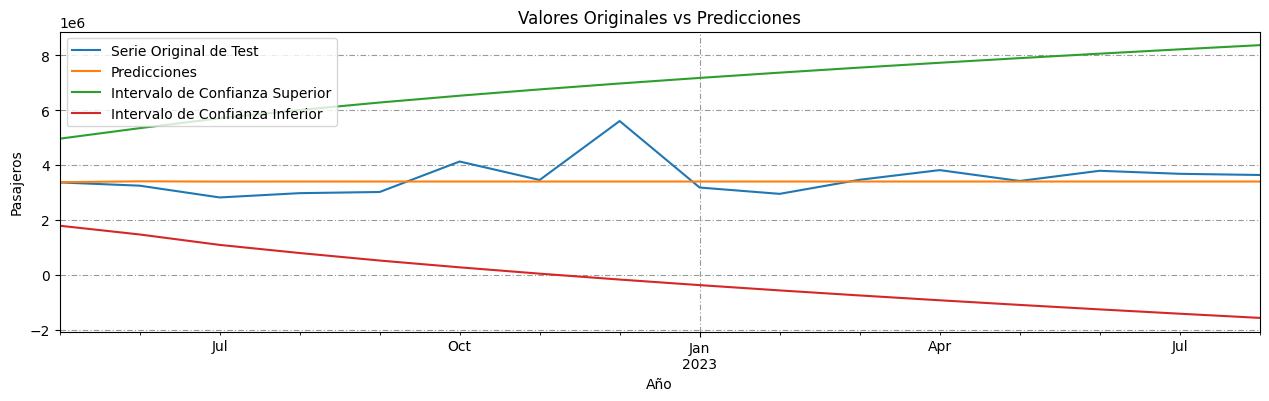

In [121]:
# Utilizando el modelo realizamos la prediccion correspondiente a los primeros 15 días del test
predicciones_arima = modelo_arima.get_forecast(16)

# Graficamos la porcion de test de la serie original junto con las predicciones y los intervalos de confianza
graficar_pred(test[:16], predicciones_arima.predicted_mean, predicciones_arima.conf_int())

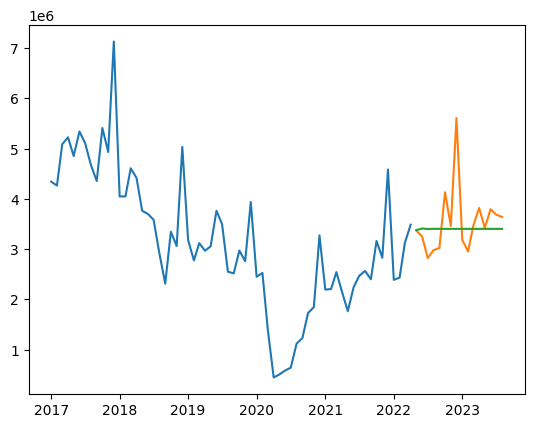

In [122]:
plt.plot(train)
plt.plot(test)
plt.plot(predicciones_arima.predicted_mean)

In [123]:
print('Sara')
evaluar_metricas(test[:16], predicciones_sarima.predicted_mean )
print('Ana')
evaluar_metricas(test[:16], predicciones_arima.predicted_mean )

Sara
MSE: 309256970025.1567
MAE: 357020.72522819834
RMSE: 556108.7753534884
MAPE: 0.0951
Ana
MSE: 424515352628.0319
MAE: 413641.1144243368
RMSE: 651548.4269246852
MAPE: 0.1068
